In [1]:
using PauliPropagation
using Random
using Optim
using Plots
Random.seed!(43)
using ReverseDiff: GradientTape, gradient!, compile, gradient
using LinearAlgebra
using StatsBase 
using GLM
using DataFrames

# Functions and Struct 

## Struct for QAOA ansatz


In [2]:
struct QAOA_ansatz
    #circuit details
    target_circuit::Vector{Gate}
    nqubits::Integer
    nlayers::Integer
    topology::Vector{Tuple{Int64, Int64}}
    repartition::Vector{Vector{Integer}}
end

In [3]:
function qaoa_setup(nqubits::Int, nlayers::Int, repartition::Vector{Vector{Int}}; topology=nothing)

    target_circuit, topology = tfimqaoacircuit(nqubits, nlayers; topology=topology)
    println("type of topology: ",typeof(topology))
    println("topology: ", topology)
    result = QAOA_ansatz(target_circuit, nqubits, nlayers,topology,repartition)
    return result
end

qaoa_setup (generic function with 1 method)

## Functions
- Circuit QAOA
- Parameter assignment for target and proposal circuits
- Loss function
- Gradient descent
- Initial mcmc circuit
- Proposal mcmc circuit
- MH algorithm

In [4]:
#QAOA circuit (Fig 10)
function tfimqaoacircuit(nqubits::Integer, nlayers::Integer; topology=nothing)
    circuit::Vector{Gate} = []

    if isnothing(topology)
        topology = bricklayertopology(nqubits;periodic=false) #chain with obc
    end

    for i in 1:nlayers
        rzzlayer!(circuit, topology)
        for qubit in 1:nqubits
            push!(circuit, CliffordGate(:S, qubit))
            push!(circuit, PauliRotation(:X, qubit, π/2)) # Fig 10: P=R_X(π/2)
            push!(circuit, PauliRotation(:Z, qubit))
            push!(circuit, PauliRotation(:X, qubit, π/2))
            push!(circuit, CliffordGate(:S, qubit))

        end
    end
    return circuit, topology
end

tfimqaoacircuit (generic function with 1 method)

In [5]:
function repartition_function(nqubits, nlayers) #qaoa repartition function
    repartition = Vector{Vector{Int}}()
    idx = 1
    for i in 1:nlayers
            push!(repartition, collect(idx:idx + (nqubits - 2)))  # First nqubits-1 indices
            idx += (nqubits - 1)
            push!(repartition, collect(idx:idx + nqubits - 1))  # Next nqubits indices
            idx += nqubits
        
    end
    return repartition
end

repartition_function (generic function with 1 method)

In [6]:
function constrain_params(thetas, repartition)
    for r in repartition
        for q in r
            thetas[q] = thetas[r[1]]
        end
    end
    return thetas
end

constrain_params (generic function with 1 method)

In [7]:
function fulllossfunction(thetas,proposal_circuit,ansatz::QAOA_ansatz;g = -2.0, max_freq=Inf, max_weight=Inf)

    type_of_coeff = eltype(thetas)
    H = PauliSum(ansatz.nqubits, type_of_coeff)
    for qind in 1:(ansatz.nqubits)
        add!(H, :X, qind, type_of_coeff(g))
    end
    for pair in ansatz.topology
        add!(H, [:Z, :Z], collect(pair), type_of_coeff(1.0))
    end
    
    wrapped_H = wrapcoefficients(H, PauliFreqTracker) #wrap to keep track of path splitting

    # We also need to run the in-place version with `!`, because by default we copy the Pauli sum
    wrapped_H = propagate!(proposal_circuit, wrapped_H, thetas; max_freq, max_weight);

    # MR: Shouldn't this be plus for QAOA?
    return overlapwithplus(wrapped_H)
end

fulllossfunction (generic function with 1 method)

In [8]:
function gd(thetas_init,closed_lossfunction, ansatz; repartition=nothing, eta=0.1, steps=100)
    
    if repartition == nothing
        repartition = ansatz.repartition
    end

    # some inputs and work buffer to play around with
    grad_array_compiled = similar(thetas_init);

    # pre-record a GradientTape for `gradsimulation` using inputs of length m with Float64 elements
    
    simulation_tape = GradientTape(closed_lossfunction, thetas_init)
    compiled_simulation_tape = compile(simulation_tape)

    opt_energy_gd = []
    thetas = thetas_init
    for i in 1:steps 
        gradient!(grad_array_compiled, simulation_tape, thetas)
        thetas .-= eta * grad_array_compiled
        constrain_params(thetas, repartition)
        opt_energy_gd = push!(opt_energy_gd, closed_lossfunction(thetas)/ansatz.nqubits)
    end

    return thetas, opt_energy_gd
end

gd (generic function with 1 method)

In [9]:
#repartition (defines which parameterized gates share the same values (a restriction of our ansatz) 
function repartition_proposal_circuit(nparams::Int, rzz_indices::Vector{Int}, rz_indices::Vector{Int})
    result = Vector{Vector{Int}}()
    tmp = []

    idx_rzz, idx_rz = 1, 1
    len_rzz, len_rz = length(rzz_indices), length(rz_indices)

    for i in 1:nparams
        if idx_rzz <= len_rzz && rzz_indices[idx_rzz] == i # && logical and
            push!(tmp, i)
            idx_rzz += 1
            if idx_rzz > len_rzz || rzz_indices[idx_rzz] != i + 1 # || logical or
                push!(result, tmp)
                tmp = []
            end
        elseif idx_rz <= len_rz && rz_indices[idx_rz] == i
            push!(tmp, i)
            idx_rz += 1
            if idx_rz > len_rz || rz_indices[idx_rz] != i + 1
                push!(result, tmp)
                tmp = []
            end
        end
    end
    return result
end

repartition_proposal_circuit (generic function with 1 method)

In [10]:
function initialize_mcmc_circuit(ansatz::QAOA_ansatz)
    
    # Choose nq*nl/2 random Pauli rotations to replace with Clifford R_Z(k_p π/2) gates.
    # The replacements are random for the whole circuit and don't repeat for each layer.

    # Get indices of Pauli rotations
    z_rot_indices = [i for i in eachindex(ansatz.target_circuit) if isa(ansatz.target_circuit[i], PauliRotation)]

    num_to_replace = div(ansatz.nqubits * ansatz.nlayers, 2)
    Random.shuffle!(z_rot_indices)
    indices_replaced = z_rot_indices[1:num_to_replace]

    # Extract qubit indices for gates to be replaced
    qubits = [ansatz.target_circuit[i].qinds for i in indices_replaced]


    # Create a modified circuit
    new_circuit = copy(ansatz.target_circuit)

    # Replace selected R_Z rotations with Clifford R_Z(k_p π/2)
    for (j, i) in enumerate(indices_replaced)
        k_p = rand(0:3)  ### Randomly select k_p from {0,1,2,3} ( NO CLEAR INDICATION in the paper)
        if length(qubits[j]) == 1
            new_circuit[i] = PauliRotation(:Z, qubits[j], k_p * π/2)  # Replace with Clifford rotation
        else
            new_circuit[i] = PauliRotation([:Z, :Z], qubits[j], k_p * π/2)  # Replace with Clifford rotation
        end
    end

    return new_circuit, indices_replaced
end

initialize_mcmc_circuit (generic function with 1 method)

In [11]:
function proposal_tfimqaoacircuit(ansatz::QAOA_ansatz,current_circuit::Vector{Gate},current_replaced_indices::Vector{Int},thetas::Vector{Float64},npairs::Integer=2)    
    # Identify all Pauli Z rotations in the circuit (includes RZZ) (Pauli Z are only the non-Cifford's here)
    proposal_circuit = deepcopy(current_circuit)
    z_rot_indices = [i for i in eachindex(proposal_circuit) if isa(proposal_circuit[i], PauliRotation)]

    #println("Z rotation indices (Non-Cliffords): ", z_rot_indices)
    #println("Indices replaced (Frozen Z rotations (Cliffords)): ", current_replaced_indices)  
    # Ensure we have enough pairs
    if length(current_replaced_indices) < npairs
        error("Not enough frozen Pauli rotations in the initialized MCMC circuit to select the value of pairs.")
    end

    # Shuffle and select n_p pairs
    Random.shuffle!(z_rot_indices)
    Random.shuffle!(current_replaced_indices)
    selected_pairs = [(z_rot_indices[i], current_replaced_indices[i]) for i in 1:npairs] 
    
    #println("Selected pairs of Cliff. and non-Clifford: ", selected_pairs) 
    #println("Circuit before replacement: ", proposal_circuit)

    function compute_distance(alpha, n)
        Pauli_z = [1 0; 0 -1]
        S_n = exp(-im * n * π / 2 * Pauli_z)
        Rz_alpha = exp(-im * alpha * Pauli_z/2)
        return LinearAlgebra.norm(Rz_alpha - S_n)
    end
    
    # Define probability distribution function
    function sample_kn(alpha)
        sigma = 0.5
        n_vals =LinRange(0,7,8) # limit n values (they repeat after 2 pi)
        distances = [compute_distance(alpha, n) for n in n_vals]
        weights = exp.(-distances.^2 ./ sigma^2)
        probs = ProbabilityWeights(weights ./ sum(weights)) 

        return first(StatsBase.sample(n_vals,probs,1))  # Sample from the distribution (using StatsBase)
    end

    #the thetas are the optimized ones from the target circuit
    function get_alpha(qubits, thetas, repartition)
        # allows to break from nested loops
        function find_alpha()
            found = false
            alpha = 0
            for k in qubits
                for (i, r) in enumerate(repartition)
                    for q in r
                        if q==k
                            alpha = thetas[i]
                            found = true
                            return alpha, found
                        end
                    end
                end
            end
            return alpha, found
        end

        alpha, found = find_alpha()
        if !found
            throw("qubits $qubits not found in repartition")
        else
            return alpha
        end
    end

    #choose left element of each pair and replace with Clifford gate S^n,sample n
    for (i, j) in selected_pairs
        qubits = proposal_circuit[i].qinds
        
        alpha = get_alpha(qubits, thetas, ansatz.repartition)
        
        k_p = sample_kn(alpha)
        # print(k_p) # SEE BELOW: we need to sample from eq 14
        if length(qubits) == 1
            proposal_circuit[i] = PauliRotation(:Z, qubits, k_p * π/2)  # Replace with Clifford rotation
        else
            proposal_circuit[i] = PauliRotation([:Z, :Z], qubits, k_p * π/2)  # Replace with Clifford rotation
        end
    end


    #then reset the right element (Clifford, FrozenGate[PauliRotation]]) to the one of the target circuit
    for (i, j) in selected_pairs 
        qubits = proposal_circuit[j].gate.qinds
        proposal_circuit[j] = ansatz.target_circuit[j] 
    end
    
    #update the replaced indices
    updated_replaced_indices = setdiff(current_replaced_indices, [j for (_, j) in selected_pairs])
    append!(updated_replaced_indices, [i for (i, _) in selected_pairs])

    return proposal_circuit, updated_replaced_indices
end

proposal_tfimqaoacircuit (generic function with 2 methods)

In [12]:
function MCMC(ansatz::QAOA_ansatz,thetas::Vector{Float64};num_acc_samples::Integer = 10,burn_in_samples =10,n_sweeps::Integer =5, npairs::Integer=2, x_sigma::Float64=0.05,x_0::Float64 =-2.1, max_freq=30, max_weight=5)
    
    #init the MCMC (we set a certain number of Pauli rotations to Clifford gates)
    initial_circuit, initial_replaced_indices = initialize_mcmc_circuit(ansatz)
    n_accepted = 0 
    
    current_circuit = deepcopy(initial_circuit)
    current_replaced_indices = deepcopy(initial_replaced_indices)
    
    acceptance_rates = Vector{Float64}()
    acc_samples = Vector{Vector{Gate}}()
    exact_energies = Vector{Float64}()
    repartition_list = []
    i = 0

    while n_accepted<num_acc_samples 
        i += 1
        proposal_circuit, updated_replaced_indices = proposal_tfimqaoacircuit(ansatz, current_circuit, current_replaced_indices,thetas, npairs) 
        rzz_indices = getparameterindices(proposal_circuit, PauliRotation, [:Z, :Z])
        rz_indices = getparameterindices(proposal_circuit, PauliRotation, [:Z])
        nparams = countparameters(proposal_circuit)
        repartition = repartition_proposal_circuit(nparams, rzz_indices, rz_indices)
        thetas_init_prop = rand((2*ansatz.nqubits-1)*ansatz.nlayers-(ansatz.nqubits*ansatz.nlayers÷2)) #need integer division! this number of replacements is hard coded in initialize_mcmc_circuit
        thetas_init_prop = constrain_params(thetas_init_prop, repartition)

        closed_lossfunction = let const_prop_circuit = proposal_circuit ,const_ansatz = ansatz, const_max_freq=max_freq, const_max_weight=max_weight 
            # these are now all captured variables with known types and we return a function that only takes thetas s.t. ReverseDiff works
            # See also "closures"
            theta -> fulllossfunction(theta, const_prop_circuit,const_ansatz; max_freq=const_max_freq, max_weight=const_max_weight)
        end

        #we need to specify we are using a different repartition now!
        x_exact = gd(thetas_init_prop,closed_lossfunction,ansatz;repartition = repartition)[2][end]

        #acceptance ratio
        acc_ratio = min(1,exp(-(x_exact-x_0)^2/(x_sigma^2)))
        if rand() < acc_ratio
            current_circuit = deepcopy(proposal_circuit)
            current_replaced_indices = deepcopy(updated_replaced_indices)
        end

        #only record after burn-in
        #only record every n_th sample (n_sweeps)
        if i > burn_in_samples
            if i%n_sweeps == 0
                n_accepted += 1
                acceptance_rate = n_accepted*n_sweeps/i
                push!(acc_samples, current_circuit)
                push!(exact_energies, x_exact)
                push!(acceptance_rates,acceptance_rate)
                push!(repartition_list, repartition)
            end
        end
    
    end

return acc_samples,exact_energies,acceptance_rates,repartition_list

end

MCMC (generic function with 1 method)

# CDR example 
### (Reproduction of Piotr's code but using PP instead of MPS)
First, we define the immutable struct `QAOA_ansatz` as we will need these parameters throughout the calculation

In [13]:
nq = 4
nl = 2
repartition = repartition_function(nq,nl)
ansatz =  qaoa_setup(nq,nl,repartition);

type of topology: Vector{Tuple{Int64, Int64}}
topology: [(1, 2), (3, 4), (2, 3)]


We run an optimization (gradient descent) of the target circuit (this is not necessarily possible). We do need the optimized target circuit for the alphas of eq. 14 (to generate close MCMC proposals to the target circuit), so if we can't calculate this we need to look for an alternative.

In [14]:
thetas_init = rand((2*ansatz.nqubits-1)*ansatz.nlayers) 
thetas_init = constrain_params(thetas_init, repartition);

In [15]:
max_freq = 30
max_weight = 5

5

Now that the system and truncations is defined, we can define a closure of the loss function and do the energy minimisation.

-2.0918214230065324
Gate[PauliRotation([:Z, :Z], [1, 2]), PauliRotation([:Z, :Z], [3, 4]), PauliRotation([:Z, :Z], [2, 3]), CliffordGate(:S, [1]), FrozenGate(PauliRotation([:X], [1]), parameter = 1.57), PauliRotation([:Z], [1]), FrozenGate(PauliRotation([:X], [1]), parameter = 1.57), CliffordGate(:S, [1]), CliffordGate(:S, [2]), FrozenGate(PauliRotation([:X], [2]), parameter = 1.57), PauliRotation([:Z], [2]), FrozenGate(PauliRotation([:X], [2]), parameter = 1.57), CliffordGate(:S, [2]), CliffordGate(:S, [3]), FrozenGate(PauliRotation([:X], [3]), parameter = 1.57), PauliRotation([:Z], [3]), FrozenGate(PauliRotation([:X], [3]), parameter = 1.57), CliffordGate(:S, [3]), CliffordGate(:S, [4]), FrozenGate(PauliRotation([:X], [4]), parameter = 1.57), PauliRotation([:Z], [4]), FrozenGate(PauliRotation([:X], [4]), parameter = 1.57), CliffordGate(:S, [4]), PauliRotation([:Z, :Z], [1, 2]), PauliRotation([:Z, :Z], [3, 4]), PauliRotation([:Z, :Z], [2, 3]), CliffordGate(:S, [1]), FrozenGate(PauliRo

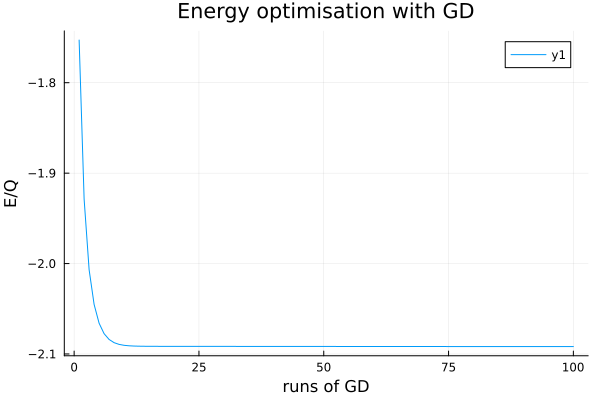

In [16]:
target_closed_lossfunction = let const_prop_circuit = ansatz.target_circuit, const_ansatz = ansatz, const_max_freq=max_freq, const_max_weight=max_weight
    # these are now all captured variables with known types and we return a function that only takes thetas s.t. ReverseDiff works
    # See also "closures"
    thetas -> fulllossfunction(thetas, const_ansatz.target_circuit, const_ansatz; max_freq=const_max_freq, max_weight=const_max_weight)
end

opt_thetas_target, opt_energy_gd = gd(thetas_init, target_closed_lossfunction, ansatz)
println(opt_energy_gd[end])
println(ansatz.target_circuit,target_closed_lossfunction(opt_thetas_target)/ansatz.nqubits) #the closed loss function only takes one argument, thetas
plot(opt_energy_gd)
plot!(title = "Energy optimisation with GD", xlabel = "runs of GD", ylabel = "E/Q")

### MCMC
Now that we have the alphas (eq 14) from the target circuit, we can run MCMC to get the set of classically efficiently simulable states $S_{\psi} =\{|\phi_i>\}$.

In [17]:
acc_samples, exact_energies_MCMC, acceptance_rates,repartition_MCMC = MCMC(ansatz,opt_thetas_target; n_sweeps = 2);

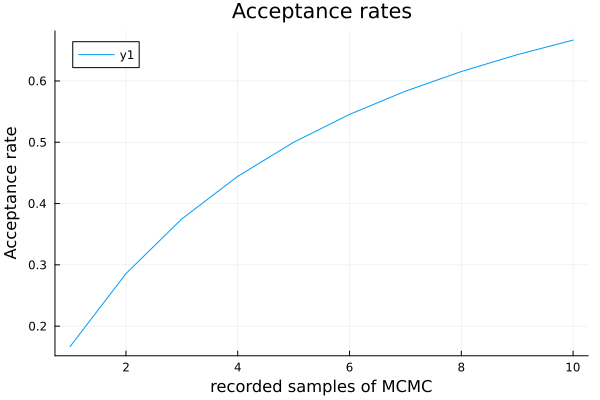

In [19]:
plot(acceptance_rates)
plot!(title = "Acceptance rates", xlabel = "recorded samples of MCMC", ylabel = "Acceptance rate")

### Noisy sample generation
- we have generated a set of classically efficiently simulable states $S_{\psi} =\{|\phi_i>\}$, so we now have our list of ground state energies and the corresponding circuits for the correction (i.e $X_{\phi_i}^{exact}$)
- there is no global noise model we can add to our training set, instead we add a layer of local depolarizing noise applied to all qubits individually  using the PP noise module to get our $X_{\phi_i}^{noisy}$

In [20]:
depol_noise_layer = [DepolarizingNoise(qind, 0.02) for qind in 1:ansatz.nqubits];

In [40]:
function noisy_expectation_values(ansatz, acc_samples, repartition; target = false)

    #define the noise layer and add to every circuit
    depol_noise_layer = [DepolarizingNoise(qind, 0.02) for qind in 1:ansatz.nqubits];

    noisy_acc_samples = deepcopy(acc_samples)
    for i in 1:length(noisy_acc_samples)
        append!(noisy_acc_samples[i], depol_noise_layer)
    end

    noisy_opt_energies = Vector{Float64}()

    for i in 1:length(noisy_acc_samples)
        thetas_init = rand((2*ansatz.nqubits-1)*ansatz.nlayers-(ansatz.nqubits*ansatz.nlayers÷2))

        if target == true
            thetas_init = rand((2*ansatz.nqubits-1)*ansatz.nlayers)
        end

        #need integer division! this number of replacements is hard coded in initialize_mcmc_circuit
        thetas_init = constrain_params(thetas_init, repartition[i])
        noisy_closed_lossfunction = let  const_circuit = noisy_acc_samples[i], const_ansatz = ansatz, const_max_freq=max_freq, const_max_weight=max_weight
            # these are now all captured variables with known types and we return a function that only takes thetas s.t. ReverseDiff works
            # See also "closures"
            thetas -> fulllossfunction(thetas, noisy_acc_samples[i], const_ansatz; max_freq=const_max_freq, max_weight=const_max_weight)
        end
        opt_thetas_noisy, opt_energy_gd_noisy = gd(thetas_init, noisy_closed_lossfunction, ansatz, repartition = repartition[i]) # need to pass repartition_MCMC!
        noisy_opt_energies = push!(noisy_opt_energies, noisy_closed_lossfunction(opt_thetas_noisy)/ansatz.nqubits)
    end 
    return noisy_opt_energies
    
end

noisy_expectation_values (generic function with 1 method)

In [41]:
noisy_opt_energies = noisy_expectation_values(ansatz, acc_samples, repartition_MCMC);

### Linear Model for Correction

In [42]:
training_data = DataFrame(x=noisy_opt_energies,y=exact_energies_MCMC)
println(training_data)
ols = lm(@formula(x ~ y), training_data)
coeffs = coef(ols)
cdr(x) = coef(ols)[1] + coef(ols)[2] * x
println(coeffs)

10×2 DataFrame
 Row │ x          y        
     │ Float64    Float64  
─────┼─────────────────────
   1 │ -0.273327  -0.25
   2 │ -1.97562   -2.03749
   3 │ -1.8472    -2.03749
   4 │ -1.82488   -1.20652
   5 │ -1.84811   -2.03715
   6 │ -1.31244   -1.31114
   7 │ -1.50047   -2.03456
   8 │ -2.02554   -2.07437
   9 │ -2.01523   -2.06383
  10 │ -2.01138   -2.05121
[-0.31710160523817454, 0.7871472440386469]


Now we compute the noisy expectation value of the target circuit.

In [44]:
noisy_target_exp_value = noisy_expectation_values(ansatz, [ansatz.target_circuit], [ansatz.repartition],target = true)[1]
println("noisy_target_exp_value: ", noisy_target_exp_value)
corrected_target_exp_value = cdr(noisy_target_exp_value)
println("corrected_target_exp_value: ", corrected_target_exp_value)
println("exact target energy: ", target_closed_lossfunction(opt_thetas_target)/ansatz.nqubits)

noisy_target_exp_value: -2.0451415149295373
corrected_target_exp_value: -1.9269291123839831
exact target energy: -2.0918214230065324


Well, science.